CSI 4106 - Introduction to Artificial Intelligence - Project W2022

Simon Paquette - spaqu044@uottawa.ca - 300044038

Image Colorization


In [2]:
from collections import Counter, OrderedDict
from pathlib import Path

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, Input, LeakyReLU
from keras.models import Model
from sklearn.model_selection import train_test_split


# IDEA

- LAB vs LUV


In [3]:
images_dir = Path("images")

WIDTH = 150
HEIGHT = 150
SIZE = (WIDTH, HEIGHT)


In [4]:
def open_image(image_path: Path) -> np.ndarray:
    """
    Open and resized an image from the pathname

    Args:
        image_path (Path): pathname of the image

    Returns:
        np.ndarray: an opened image
    """
    opened_image = cv.imread(str(image_path), cv.IMREAD_COLOR)
    resized_image = cv.resize(opened_image, SIZE)
    image = resized_image.astype("uint8")
    return image


def show_image(image: np.ndarray):
    """
    Show an image with plt

    Args:
        image (np.ndarray): an opened image
    """
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    plt.show()


def bgr_to_l_ab_channels(bgr_image: np.ndarray) -> "tuple[np.ndarray, np.ndarray]":
    """
    From a bgr image, convert to the l* and a*b* channels

    Args:
        bgr_image (np.ndarray): an opened bgr image

    Returns:
        tuple[np.ndarray, np.ndarray]: the l* channel and the ab* channel
    """
    lab_image = cv.cvtColor(bgr_image, cv.COLOR_BGR2LAB)
    l_channel, a_channel, b_channel = cv.split(lab_image)
    ab_channel = cv.merge([a_channel, b_channel])
    return (l_channel, ab_channel)


def l_ab_channels_to_bgr(l_channel: np.ndarray, ab_channel: np.ndarray) -> np.ndarray:
    """
    Create a bgr image from merging a l* channel and a a*b* channel

    Args:
        l_channel (np.ndarray): l* channel
        ab_channel (np.ndarray): a*b* channel

    Returns:
        np.ndarray: an opened bgr image
    """
    merged_image = cv.merge([l_channel, ab_channel])
    bgr_image = cv.cvtColor(merged_image, cv.COLOR_LAB2BGR)
    return bgr_image


def counter_ndarray(array: np.ndarray) -> OrderedDict:
    """
    Helper function:
    Apply a counter to an array to evaluate the distribution of all pixel values

    Args:
        array (np.ndarray): an numpy array

    Returns:
        OrderedDict: the dict of a counter
    """
    flat = array.flatten()
    counts = dict(Counter(flat))
    ordered = OrderedDict(sorted(counts.items()))
    return ordered


def show_extracted_image(image_path: Path):
    """
    Helper function:
    Show the original image and its grayscale representation

    Args:
        image_path (Path): pathname of the image
    """
    raw_image = open_image(image_path)
    l_channel, ab_channel = bgr_to_l_ab_channels(raw_image)
    show_image(raw_image)
    show_image(l_channel)


def get_train_test_from_dir(images_dir: Path) -> tuple:
    """
    Get data and labels for training and testing

    Args:
        images_dir (Path): pathname directory containing all the images

    Returns:
        tuple: x_train, x_test, y_train, y_test
    """
    pathnames = list(images_dir.iterdir())
    x_image, y_image = [], []
    for pathname in pathnames:
        image = open_image(pathname)
        l_channel, ab_channel = bgr_to_l_ab_channels(image)
        x_image.append(l_channel)
        y_image.append(ab_channel)
    data = np.array(x_image)
    labels = np.array(y_image)
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)
    return (x_train, x_test, y_train, y_test)


def predict_1_image(array: np.ndarray, model) -> np.ndarray:
    """
    Color prediction from an image (using the grayscale) created by the model

    Args:
        array (np.ndarray): an opened image
        model (_type_): a TF model for colorization

    Returns:
        np.ndarray: a new predicted colored image
    """
    l_channel, ab_channel = bgr_to_l_ab_channels(array)
    grayscale = l_channel.reshape(1, HEIGHT, WIDTH, 1)
    ab_prediction = model.predict(grayscale)
    ab_prediction = ab_prediction.reshape(HEIGHT, WIDTH, 2)
    ab_prediction[ab_prediction < 0] = 0
    ab_prediction = ab_prediction.astype("uint8")
    new_image = l_ab_channels_to_bgr(l_channel, ab_prediction)
    return new_image


def create_model_colorization(model_func):
    """
    Define the colorization model

    Args:
        model_func (_type_): a function that create a TF model with different testing layer

    Returns:
        _type_: a TF colorization model with layers
    """
    input_layer = Input(shape=(HEIGHT, WIDTH, 1))
    output_layer = model_func(input_layer)
    model_colorization = Model(inputs=input_layer, outputs=output_layer)
    model_colorization.summary()
    return model_colorization


def train_pipeline(
    model_func, compile_func, fit_func, data: np.ndarray, labels: np.ndarray
):
    """
    A pipeline to apply a training step. A model creation, compilation and fit from training data and labels

    Args:
        model_func (_type_): a function that create a TF model with different testing layers
        compile_func (_type_): a function that compile a TF model with different testing optimizers, losses and metrics
        fit_func (_type_): a function that fit a TF model with different testing parameters like epochs
        data (np.ndarray): training data
        labels (np.ndarray): training labels

    Returns:
        _type_: a trained TF colorization model
    """
    model = create_model_colorization(model_func)
    compile_func(model)
    fit_func(model, data, labels)
    return model


def test_eval(model, data: np.ndarray, labels: np.ndarray):
    """
    Evaluate the model with testing data and labels

    Args:
        model (_type_): a trained TF colorization model
        data (np.ndarray): testing data
        labels (np.ndarray): testing labels
    """
    model.evaluate(data, labels, verbose=2)


In [22]:
def model_func_1(input_layer):
    """
    Model with layers:

    - Conv2D

    - LeakyReLU

    Args:
        input_layer (_type_): first layer of the model

    Returns:
        _type_: a model with layers
    """
    model = Conv2D(16, (3, 3), padding="same", strides=1)(input_layer)
    model = LeakyReLU()(model)
    model = Conv2D(32, (3, 3), padding="same", strides=1)(model)
    model = LeakyReLU()(model)
    model = Conv2D(64, (3, 3), padding="same", strides=1)(model)
    model = LeakyReLU()(model)
    model = Conv2D(32, (3, 3), padding="same", strides=1)(model)
    model = LeakyReLU()(model)
    model = Conv2D(16, (3, 3), padding="same", strides=1)(model)
    model = LeakyReLU()(model)
    model = Conv2D(2, (3, 3), padding="same", strides=1)(model)
    return model


def compile_func_1(model):
    """
    Model compilation:

    - Adam

    - MSE

    Args:
        model (_type_): a model with layers
    """
    model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mse"])


def fit_func_1(model, data: np.ndarray, labels: np.ndarray):
    """
    Model fit:

    - epoch=5

    - shuffle

    Args:
        model (_type_): a model with layers
        data (np.ndarray): l* channel
        labels (np.ndarray): a*b* channel
    """
    model.fit(data, labels, epochs=5, shuffle=True)


In [6]:
x_train, x_test, y_train, y_test = get_train_test_from_dir(images_dir)


In [23]:
model = train_pipeline(model_func_1, compile_func_1, fit_func_1, x_train, y_train)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_19 (Conv2D)          (None, 150, 150, 16)      160       
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 150, 150, 16)      0         
                                                                 
 conv2d_20 (Conv2D)          (None, 150, 150, 32)      4640      
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 150, 150, 32)      0         
                                                                 
 conv2d_21 (Conv2D)          (None, 150, 150, 64)      18496     
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 150, 150, 64)      0   

In [17]:
test_eval(model, x_test, y_test)


45/45 - 24s - loss: 1725.9591 - accuracy: 0.4826 - 24s/epoch - 529ms/step


PREDICT IMAGE


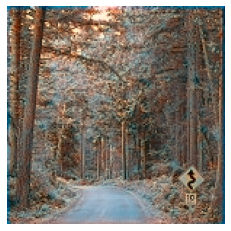

REAL IMAGE


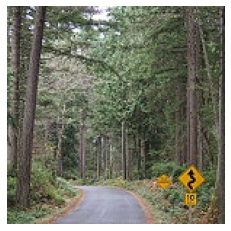

In [34]:
n_jpg = 6000
image_path = Path(images_dir, f"{n_jpg}.jpg")
raw_image = open_image(image_path)
new_image = predict_1_image(raw_image, model)
print("PREDICT IMAGE")
show_image(new_image)
print("REAL IMAGE")
show_image(raw_image)
